<a href="https://colab.research.google.com/github/ceciliavoronoff/Arquivos/blob/master/TCC_dados_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando Bibliotecas

In [ ]:
!pip install yfinance

In [ ]:
!pip install plotly==5.5.0

In [ ]:
!pip install kats

In [ ]:
!pip install gdown

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import datetime
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats.mstats import winsorize
import kats
import gdown
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

#Coleta de dados

In [ ]:
index = '^BVSP'
first_day = pd.to_datetime('2007-01-01')
last_day = pd.to_datetime('2021-12-31')
df = pdr.get_data_yahoo(index, start=first_day, end=last_day, parse_dates=['Date'], index_col='Date')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200
2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800
2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000
2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000
2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100


##Análise Inicial

Verifica se todos valores estão presentes.

In [ ]:
df.all()

Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume       False
dtype: bool

Como temos valores faltantes no volume, e nenhuma solução evidente para tratá-los, excluímos esse dado do dataframe.

In [ ]:
df = df.drop(columns=['Volume'])
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0
2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0
2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0
2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0
2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0


A diferença entre preço de fechamento e preço de fechamento ajustado acontece por eventos como splits. Não faz sentido haver essa diferença em um índice. 

In [ ]:
comp = np.where(df['Adj Close'] != df['Close'], True, False)
comp.any()

False

Depois de verificar que os valores são sempre iguais, removemos a coluna redundante.

In [ ]:
df = df.drop(columns=['Adj Close'])
df.tail()

,Open,High,Low,Close
Date,,,,
2021-12-23,105251.0,105453.0,104637.0,104891.0
2021-12-27,104892.0,105694.0,104798.0,105531.0
2021-12-28,105555.0,105652.0,104503.0,104864.0
2021-12-29,104863.0,105190.0,103851.0,104107.0
2021-12-30,104106.0,105269.0,104106.0,104822.0


Por fim, criamos a variável discreta que indica alta ou baixa, e removemos o primeiro valor, que não pode ser computado. Usamos 1 para indicar alta e 0, baixa. 0 também trata o caso improvável dos valores serem idênticos.

In [ ]:
df['Shift'] = df['Close'].shift(1)
df['Tendência'] = np.where(df['Close'] > df['Close'].shift(1), 1, 0)
df = df.dropna()
df.head(15)

,Open,High,Low,Close,Shift,Tendência
Date,,,,,,
2007-01-03,45379.0,45379.0,44284.0,44445.0,45383.0,0
2007-01-04,44442.0,44442.0,43623.0,44020.0,44445.0,0
2007-01-05,44019.0,44081.0,42160.0,42245.0,44020.0,0
2007-01-08,42249.0,42926.0,42144.0,42830.0,42245.0,1
2007-01-09,42831.0,43001.0,41438.0,42007.0,42830.0,0
2007-01-10,42001.0,42336.0,41266.0,42336.0,42007.0,1
2007-01-11,42336.0,43128.0,41940.0,42670.0,42336.0,1
2007-01-12,42669.0,43188.0,42526.0,43095.0,42670.0,1
2007-01-15,43095.0,43473.0,42875.0,42919.0,43095.0,0


Confirmando que o número de ocorrências onde os valores são idênticos.

In [ ]:
comp = np.where(df['Close'] == df['Shift'], True, False)
ocorrencias = (comp == True).sum()
print(f'Número de ocorrências: {ocorrencias}\nPercentual do dataset: {round((ocorrencias/len(df))*100, 2)}%')

Número de ocorrências: 3
Percentual do dataset: 0.08%


Como o percentual dessas ocorrências é muito baixo, neste momento, escolhemos não tratar esse caso.

Por fim, como a coluna 'Shift' só é necessária para o cálculo da coluna 'Tendência', também a excluímos do dataframe.

In [ ]:
df = df.drop(["Shift"], axis=1)
df.head()

,Open,High,Low,Close,Tendência
Date,,,,,
2007-01-03,45379.0,45379.0,44284.0,44445.0,0
2007-01-04,44442.0,44442.0,43623.0,44020.0,0
2007-01-05,44019.0,44081.0,42160.0,42245.0,0
2007-01-08,42249.0,42926.0,42144.0,42830.0,1
2007-01-09,42831.0,43001.0,41438.0,42007.0,0


#Análise Exploratória

##Inspeção dos dados

Precisamos avaliar se todos os valores são numéricos. Para isso, vamos comparar o dataframe com uma cópia dele mesmo contendo apenas as colunas em números.

In [ ]:
df.compare(df._get_numeric_data())

Date


O resultado dessa função são as diferenças entre os dois dataframes. Podemos ver que apenas o rótulo do índice não é um valor numérico.

In [ ]:
df.index

DatetimeIndex(['2007-01-03', '2007-01-04', '2007-01-05', '2007-01-08',
               '2007-01-09', '2007-01-10', '2007-01-11', '2007-01-12',
               '2007-01-15', '2007-01-16',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=3705, freq=None)

No entanto, quando analisamos o índice, vemos que seu tipo de dado é *datetime64*. No entanto, isso não afeta o processamento, então não vamos alterar isso.

##Análise descritiva

In [ ]:
df[['Open', 'High', 'Low', 'Close']].describe()

,Open,High,Low,Close
count,3705.000000,3705.000000,3705.000000,3705.000000
mean,68300.561943,69000.014035,67600.647773,68315.492038
std,21705.641471,21834.278086,21575.290346,21711.742075
min,29438.000000,31480.000000,29435.000000,29435.000000
25%,53232.000000,53866.000000,52688.000000,53234.000000
50%,61911.000000,62494.000000,61300.000000,61923.000000
75%,76671.000000,77704.000000,76026.000000,76678.000000
max,130776.000000,131190.000000,129526.000000,130776.000000


##Identificação de outliers

In [ ]:
for column in ('Open', 'High', 'Low', 'Close'):
    aux = df[[column]].describe()
    valorMin = np.float64(aux.loc['min']).item()
    valorMax = np.float64(aux.loc['max']).item()
    q1 = np.float64(aux.loc['25%']).item()
    q3 = np.float64(aux.loc['75%']).item()
    intervalo = 1.5 * (q3-q1)
    limite_min = max((q1 - intervalo), valorMin)
    limite_max = min((q3 + intervalo), valorMax)
    normais = np.where(df[column] > limite_min, df[column], np.nan)
    menores = np.isnan(normais).sum()
    print('Dados da feature: ', column)
    print(f'Quantidade de outliers inferiores: {menores}')
    print(f'Percentual do dataset: {round(menores/len(normais), 6)}%')
    normais = np.where(df[column] < limite_max, df[column], np.nan)
    maiores = np.isnan(normais).sum()
    print(f'Quantidade de outliers superiores: {maiores}')
    print(f'Percentual do dataset: {round(maiores/len(normais), 6)}%')
    print(f'\nQuantidade total de outliers: {menores+maiores}')
    print(f'Percentual do dataset: {round((menores+maiores)/len(normais), 6)}%\n')
    
    #plt.figure()
    #sns.boxplot(df[column])
    #plt.show()
    
    fig = go.Figure()
    fig.add_trace(go.Box(x=df[column], name=column))
    fig.show()
    print('-------------------------------------------------------------------------')

Dados da feature:  Open
Quantidade de outliers inferiores: 1
Percentual do dataset: 0.00027%
Quantidade de outliers superiores: 248
Percentual do dataset: 0.066937%

Quantidade total de outliers: 249
Percentual do dataset: 0.067206%



-------------------------------------------------------------------------
Dados da feature:  High
Quantidade de outliers inferiores: 1
Percentual do dataset: 0.00027%
Quantidade de outliers superiores: 245
Percentual do dataset: 0.066127%

Quantidade total de outliers: 246
Percentual do dataset: 0.066397%



-------------------------------------------------------------------------
Dados da feature:  Low
Quantidade de outliers inferiores: 1
Percentual do dataset: 0.00027%
Quantidade de outliers superiores: 242
Percentual do dataset: 0.065317%

Quantidade total de outliers: 243
Percentual do dataset: 0.065587%



-------------------------------------------------------------------------
Dados da feature:  Close
Quantidade de outliers inferiores: 1
Percentual do dataset: 0.00027%
Quantidade de outliers superiores: 247
Percentual do dataset: 0.066667%

Quantidade total de outliers: 248
Percentual do dataset: 0.066937%



-------------------------------------------------------------------------


#Plotando a série de preço bruta

In [ ]:
serie_ibov = px.line(df, x=df.index, y=df["Close"])
serie_ibov.show()

#Pré-processamento

##Winsorização

In [ ]:
df_win = df.copy(deep=True)
for column in ('Open', 'High', 'Low', 'Close'):
    df_win[[column]] = winsorize(df_win[[column]], limits=[0.01, 0.01])
    
for column in ('Open', 'High', 'Low', 'Close'):    
    aux = df_win[[column]].describe()
    valorMin = np.float64(aux.loc['min']).item()
    valorMax = np.float64(aux.loc['max']).item()
    q1 = np.float64(aux.loc['25%']).item()
    q3 = np.float64(aux.loc['75%']).item()
    intervalo = 1.5 * (q3-q1)
    limite_min = max(q1 - intervalo, valorMin)
    limite_max = min((q3 + intervalo), valorMax)
    normais = np.where(df_win[column] > limite_min, df_win[column], np.nan)
    menores = np.isnan(normais).sum()
    print('Dados da feature: ', column)
    print(f'Quantidade de outliers inferiores: {menores}')
    print(f'Percentual do dataset: {round(menores/len(normais), 6)}%')
    normais = np.where(df_win[column] < limite_max, df_win[column], np.nan)
    maiores = np.isnan(normais).sum()
    print(f'Quantidade de outliers superiores: {maiores}')
    print(f'Percentual do dataset: {round(maiores/len(normais), 6)}%')
    print(f'\nQuantidade total de outliers: {menores+maiores}')
    print(f'Percentual do dataset: {round((menores+maiores)/len(normais), 6)}%\n')
    
    fig = go.Figure()
    fig.add_trace(go.Box(x=df_win[column], name=column))
    fig.show()
    print('-------------------------------------------------------------------------')

Dados da feature:  Open
Quantidade de outliers inferiores: 38
Percentual do dataset: 0.010256%
Quantidade de outliers superiores: 248
Percentual do dataset: 0.066937%

Quantidade total de outliers: 286
Percentual do dataset: 0.077193%



-------------------------------------------------------------------------
Dados da feature:  High
Quantidade de outliers inferiores: 38
Percentual do dataset: 0.010256%
Quantidade de outliers superiores: 245
Percentual do dataset: 0.066127%

Quantidade total de outliers: 283
Percentual do dataset: 0.076383%



-------------------------------------------------------------------------
Dados da feature:  Low
Quantidade de outliers inferiores: 38
Percentual do dataset: 0.010256%
Quantidade de outliers superiores: 242
Percentual do dataset: 0.065317%

Quantidade total de outliers: 280
Percentual do dataset: 0.075574%



-------------------------------------------------------------------------
Dados da feature:  Close
Quantidade de outliers inferiores: 38
Percentual do dataset: 0.010256%
Quantidade de outliers superiores: 247
Percentual do dataset: 0.066667%

Quantidade total de outliers: 285
Percentual do dataset: 0.076923%



-------------------------------------------------------------------------


Basicamente, a winsorização consiste numa limitação dos valores extremos com o objetivo de reduzir o impacto de outliers. O nome se dá em homenagem ao engenheiro que se tornou estatístico, [Charles P. Winsor](https://stringfixer.com/pt/Charles_Winsor). A estratégia é substituir os valores outliers pelos valores correspondentes aos limites inferior e superior na distribuição. Então, por exemplo, numa winsorização de 95%, como a definida no experimento acima, os elementos abaixo do 5° quartil serão definidos como o valor do 5° quartil, e os elementos acima do 95° percentil serão definidos como o valor do 95° percentil. 

###Série de preço winsorizada

In [ ]:
serie_ibov_winsorizada = px.line(df_win, x=df_win.index, y=df_win["Close"])
serie_ibov_winsorizada.show()

##Suavização por médias móveis - 5 dias

In [ ]:
df_SMA = df.copy(deep=True)

for column in ('Open', 'High', 'Low', 'Close'):
  df_SMA[[column]] = df[[column]].rolling(window=5).mean()

df_SMA.dropna(inplace=True)
df_SMA.head()

for column in ('Open', 'High', 'Low', 'Close'):    
    aux = df_SMA[[column]].describe()
    valorMin = np.float64(aux.loc['min']).item()
    valorMax = np.float64(aux.loc['max']).item()
    q1 = np.float64(aux.loc['25%']).item()
    q3 = np.float64(aux.loc['75%']).item()
    intervalo = 1.5 * (q3-q1)
    limite_min = max(q1 - intervalo, valorMin)
    limite_max = min((q3 + intervalo), valorMax)
    normais = np.where(df_SMA[column] > limite_min, df_SMA[column], np.nan)
    menores = np.isnan(normais).sum()
    print('Dados da feature: ', column)
    print(f'Quantidade de outliers inferiores: {menores}')
    print(f'Percentual do dataset: {round(menores/len(normais), 6)}%')
    normais = np.where(df_SMA[column] < limite_max, df_SMA[column], np.nan)
    maiores = np.isnan(normais).sum()
    print(f'Quantidade de outliers superiores: {maiores}')
    print(f'Percentual do dataset: {round(maiores/len(normais), 6)}%')
    print(f'\nQuantidade total de outliers: {menores+maiores}')
    print(f'Percentual do dataset: {round((menores+maiores)/len(normais), 6)}%\n')
    
    fig = go.Figure()
    fig.add_trace(go.Box(x=df_SMA[column], name=column))
    fig.show()
    print('-------------------------------------------------------------------------')

Dados da feature:  Open
Quantidade de outliers inferiores: 1
Percentual do dataset: 0.00027%
Quantidade de outliers superiores: 248
Percentual do dataset: 0.067009%

Quantidade total de outliers: 249
Percentual do dataset: 0.067279%



-------------------------------------------------------------------------
Dados da feature:  High
Quantidade de outliers inferiores: 1
Percentual do dataset: 0.00027%
Quantidade de outliers superiores: 249
Percentual do dataset: 0.067279%

Quantidade total de outliers: 250
Percentual do dataset: 0.067549%



-------------------------------------------------------------------------
Dados da feature:  Low
Quantidade de outliers inferiores: 1
Percentual do dataset: 0.00027%
Quantidade de outliers superiores: 246
Percentual do dataset: 0.066469%

Quantidade total de outliers: 247
Percentual do dataset: 0.066739%



-------------------------------------------------------------------------
Dados da feature:  Close
Quantidade de outliers inferiores: 1
Percentual do dataset: 0.00027%
Quantidade de outliers superiores: 245
Percentual do dataset: 0.066198%

Quantidade total de outliers: 246
Percentual do dataset: 0.066469%



-------------------------------------------------------------------------


###Série de preço suavizada por Média Móvel

In [ ]:
serie_ibov_SMA = px.line(df_SMA, x=df_SMA.index, y=df_SMA["Close"])
serie_ibov_SMA.show()

##Decomposição Sazonal

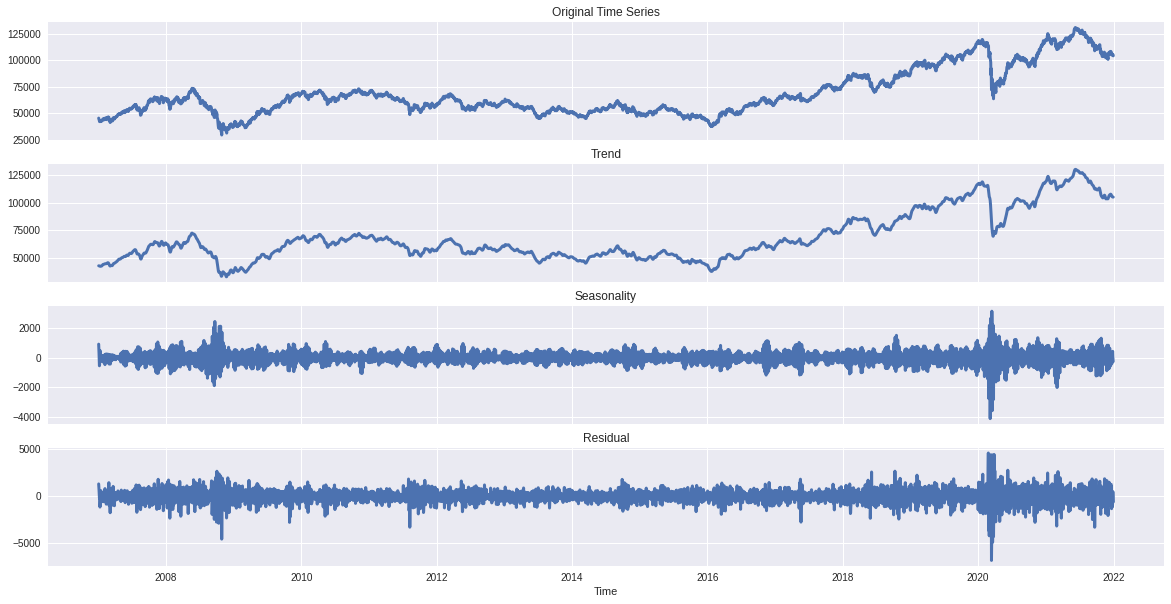

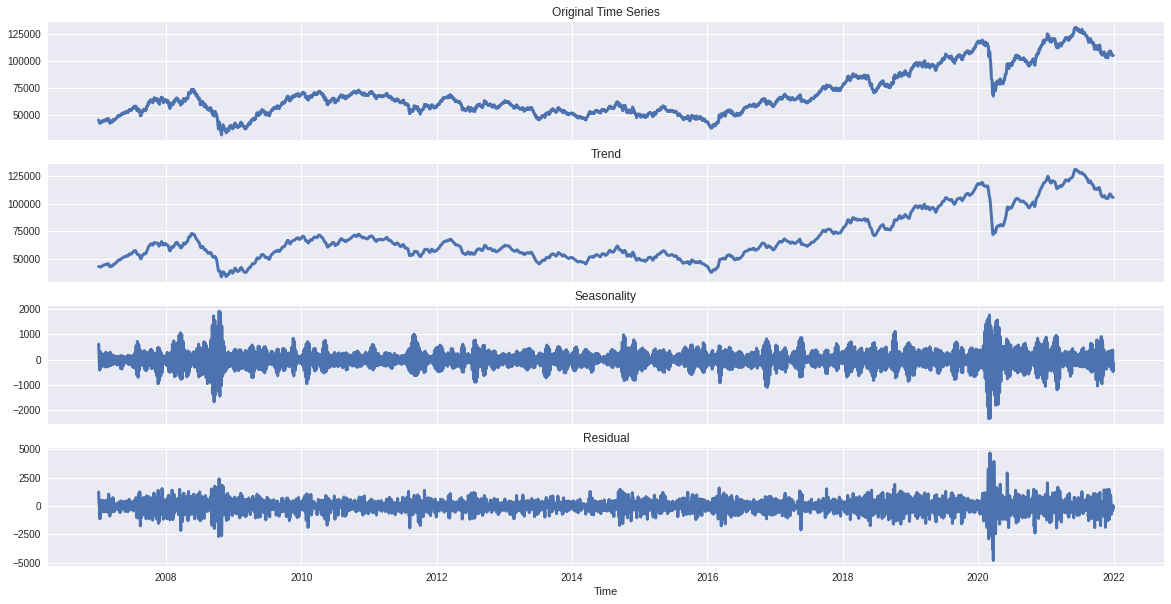

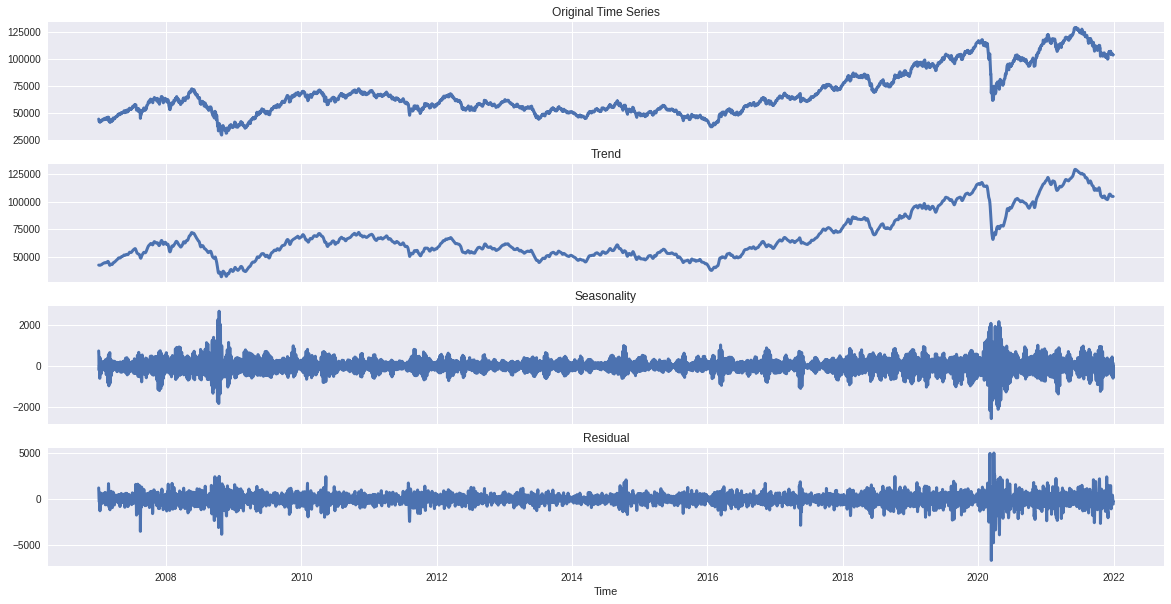

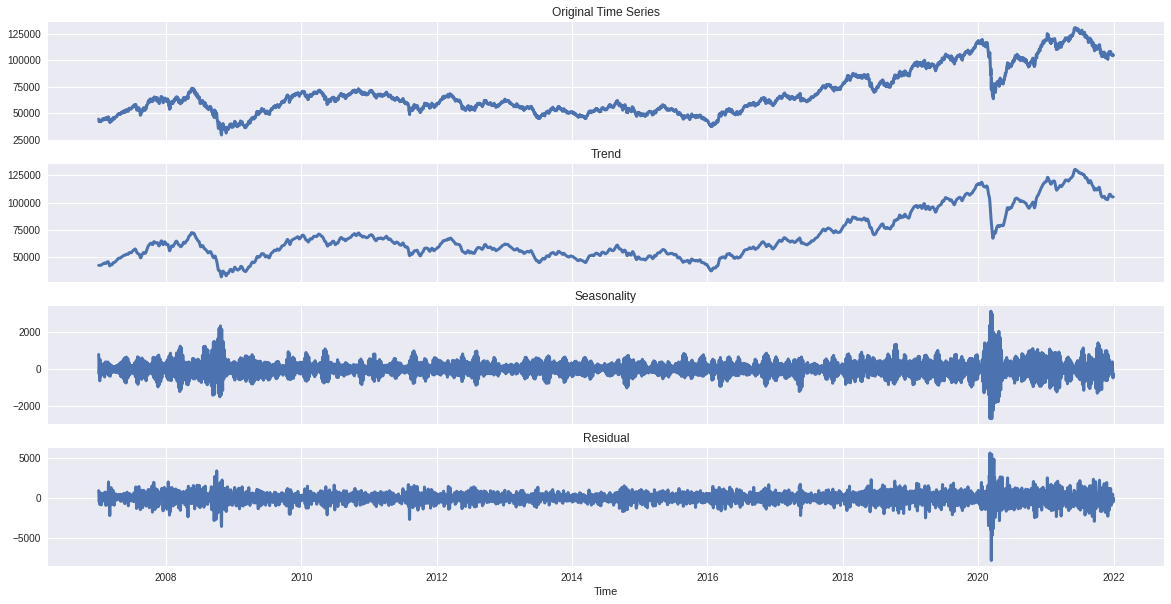

In [ ]:
from kats.consts import TimeSeriesData
from kats.utils.decomposition import TimeSeriesDecomposition

df_seasonal = df.copy(deep=True).reset_index()
df_seasonal.head()

df_open = df_seasonal[['Date', 'Open']]
df_high = df_seasonal[['Date', 'High']]
df_low = df_seasonal[['Date', 'Low']]
df_close = df_seasonal[['Date', 'Close']]

df_open = df_open.rename(columns={'Date': 'time', 'Open': 'value'})
df_high = df_high.rename(columns={'Date': 'time', 'High': 'value'})
df_low = df_low.rename(columns={'Date': 'time', 'Low': 'value'})
df_close = df_close.rename(columns={'Date': 'time', 'Close': 'value'})

ts_open = TimeSeriesData(df_open)
ts_high = TimeSeriesData(df_high)
ts_low = TimeSeriesData(df_low)
ts_close = TimeSeriesData(df_close)

decomposer = TimeSeriesDecomposition(ts_open, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

decomposer = TimeSeriesDecomposition(ts_high, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

decomposer = TimeSeriesDecomposition(ts_low, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

decomposer = TimeSeriesDecomposition(ts_close, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()


In [58]:
from kats.detectors.outlier import OutlierDetector

outlier_detector = OutlierDetector(ts_open, "additive")
ts_open = outlier_detector.remover(interpolate=True)

outlier_detector = OutlierDetector(ts_high, "additive")
ts_high = outlier_detector.remover(interpolate=True)

outlier_detector = OutlierDetector(ts_low, "additive")
ts_low = outlier_detector.remover(interpolate=True)

outlier_detector = OutlierDetector(ts_close, "additive")
ts_close = outlier_detector.remover(interpolate=True)

open = ts_open.to_dataframe()
high = ts_high.to_dataframe()
low = ts_low.to_dataframe()
close = ts_close.to_dataframe()

open.value


0        45379.0
1        44442.0
2        44019.0
3        42249.0
4        42831.0
          ...   
3700    105251.0
3701    104892.0
3702    105555.0
3703    104863.0
3704    104106.0
Name: value, Length: 3705, dtype: float64

In [56]:
df_seasonal = df.copy(deep=True)
df_seasonal['Open'] = open['value']
df_seasonal['High'] = high['value']
df_seasonal['Low'] = low['value']
df_seasonal['Close'] = close['value']

df_seasonal.tail()

,Open,High,Low,Close,Tendência
Date,,,,,
2021-12-23,NaN,NaN,NaN,NaN,0
2021-12-27,NaN,NaN,NaN,NaN,1
2021-12-28,NaN,NaN,NaN,NaN,0
2021-12-29,NaN,NaN,NaN,NaN,0
2021-12-30,NaN,NaN,NaN,NaN,1


###Decomposição das componentes da série


In [ ]:
date = {}
trend = {}
seasonal = {}

result_add = seasonal_decompose(df['Open'].dropna(), model = 'additive', freq=5)
trend = result_add.trend
seasonal = result_add.seasonal

plt.rcParams.update({'figure.figsize': (20, 10)})
#print(column)
#result_mul.plot().suptitle('Multiplicative Decompose - '+ column, fontsize=30)
result_add.plot().suptitle('Additive Decompose - '+ 'Open', fontsize=30)
plt.show()


In [ ]:
date = {}
trend = {}
seasonal = {}

result_add = seasonal_decompose(df['High'].dropna(), model = 'additive', freq=5)
trend = result_add.trend
seasonal = result_add.seasonal

plt.rcParams.update({'figure.figsize': (20, 10)})
#print(column)
#result_mul.plot().suptitle('Multiplicative Decompose - '+ column, fontsize=30)
result_add.plot().suptitle('Additive Decompose - '+ 'High', fontsize=30)
plt.show()

In [ ]:
date = {}
trend = {}
seasonal = {}

result_add = seasonal_decompose(df['Low'].dropna(), model = 'additive', freq=5)
trend = result_add.trend
seasonal = result_add.seasonal

plt.rcParams.update({'figure.figsize': (20, 10)})
#print(column)
#result_mul.plot().suptitle('Multiplicative Decompose - '+ column, fontsize=30)
result_add.plot().suptitle('Additive Decompose - '+ 'Low', fontsize=30)
plt.show()

In [ ]:
date = {}
trend = {}
seasonal = {}

result_add = seasonal_decompose(df['Close'].dropna(), model = 'additive', freq=5)
trend = result_add.trend
seasonal = result_add.seasonal

plt.rcParams.update({'figure.figsize': (20, 10)})
#print(column)
#result_mul.plot().suptitle('Multiplicative Decompose - '+ column, fontsize=30)
result_add.plot().suptitle('Additive Decompose - '+ 'Close', fontsize=30)
plt.show()

##Janelas deslizantes

In [ ]:
def window_generator(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps

        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)


##Gerando o dataframe com as features "janeladas" - Análise multivariada

##Janelado original

In [ ]:
df_multivariado = list()
for column in df:
    seq, ts = window_generator(df[column].values, 3)
    temp1 = pd.DataFrame(seq)
    temp1.rename(columns={0 : f'{column}_t3', 1 : f'{column}_t2', 2 : f'{column}_t1'}, inplace=True)
    temp1[column] = ts.tolist()
    df_multivariado.append(temp1)

df_multivariado = pd.concat(df_multivariado, axis=1)
df_multivariado.head()

##Janelado winsorizado

In [ ]:
df_winsorizado_multivariado = list()
for column in df_win:
    seq, ts = window_generator(df_win[column].values, 3)
    temp1 = pd.DataFrame(seq)
    temp1.rename(columns={0 : f'{column}_t3', 1 : f'{column}_t2', 2 : f'{column}_t1'}, inplace=True)
    temp1[column] = ts.tolist()
    df_winsorizado_multivariado.append(temp1)

df_winsorizado_multivariado = pd.concat(df_winsorizado_multivariado, axis=1)
df_winsorizado_multivariado.head()

##Janelado Suavizado por médias móveis

In [ ]:
df_SMA5_multivariado = list()
for column in df_SMA:
    seq, ts = window_generator(df_SMA[column].values, 3)
    temp1 = pd.DataFrame(seq)
    temp1.rename(columns={0 : f'{column}_t3', 1 : f'{column}_t2', 2 : f'{column}_t1'}, inplace=True)
    temp1[column] = ts.tolist()
    df_SMA5_multivariado.append(temp1)

df_SMA5_multivariado = pd.concat(df_SMA5_multivariado, axis=1)
df_SMA5_multivariado.head()

##Janelado Suavizado por decomposição da componente sazonal

##Divisão treino-teste

In [ ]:
split = int(df_multivariado.shape[0] * .7)

df_multivariado_train = df_multivariado.loc[:split]
df_multivariado_test = df_multivariado.loc[split:]

df_winsorizado_multivariado_train = df_winsorizado_multivariado.loc[:split]
df_winsorizado_multivariado_test = df_winsorizado_multivariado.loc[split:]

df_SMA5_multivariado_train = df_SMA5_multivariado.loc[:split]
df_SMA5_multivariado_test =  df_SMA5_multivariado.loc[split:]

In [ ]:
y_multivariado_train = df_multivariado_train['Tendência']
X_multivariado_train = df_multivariado_train.drop(columns= 'Tendência')

y_multivariado_test = df_multivariado_test['Tendência']
X_multivariado_test = df_multivariado_test.drop(columns= 'Tendência')

y_winsorizado_multivariado_train = df_multivariado_train['Tendência']
X_winsorizado_multivariado_train = df_multivariado_train.drop(columns= 'Tendência')

y_winsorizado_multivariado_test = df_multivariado_test['Tendência']
X_winsorizado_multivariado_test = df_multivariado_test.drop(columns= 'Tendência')

y_SMA5_multivariado_train = df_SMA5_multivariado_train['Tendência']
X_SMA5_multivariado_train = df_SMA5_multivariado_train.drop(columns = 'Tendência')

y_SMA5_multivariado_test = df_SMA5_multivariado_test['Tendência']
X_SMA5_multivariado_test = df_SMA5_multivariado_test.drop(columns = 'Tendência')


##Normalização

In [ ]:
scaler = StandardScaler()

norm_multivariado_train = scaler.fit_transform(X_multivariado_train)
norm_multivariado_test = scaler.transform(X_multivariado_test)

norm_multivariado_train = pd.DataFrame(norm_multivariado_train, index=X_multivariado_train.index, columns=X_multivariado_train.columns)
norm_multivariado_test = pd.DataFrame(norm_multivariado_test, index=X_multivariado_test.index, columns=X_multivariado_test.columns)

In [ ]:
scaler = StandardScaler()

norm_winsorizado_multivariado_train = scaler.fit_transform(X_winsorizado_multivariado_train)
norm_winsorizado_multivariado_test = scaler.transform(X_winsorizado_multivariado_test)

norm_winsorizado_multivariado_train = pd.DataFrame(norm_winsorizado_multivariado_train, index=X_winsorizado_multivariado_train.index, columns=X_winsorizado_multivariado_train.columns)
norm_winsorizado_multivariado_test = pd.DataFrame(norm_winsorizado_multivariado_test, index=X_winsorizado_multivariado_test.index, columns=X_winsorizado_multivariado_test.columns)

In [ ]:
scaler = StandardScaler()

norm_SMA5_multivariado_train = scaler.fit_transform(X_SMA5_multivariado_train)
norm_SMA5_multivariado_test = scaler.transform(X_SMA5_multivariado_test)

norm_SMA5_multivariado_train = pd.DataFrame(norm_SMA5_multivariado_train, index=X_SMA5_multivariado_train.index, columns=X_SMA5_multivariado_train.columns)
norm_SMA5_multivariado_test = pd.DataFrame(norm_SMA5_multivariado_test, index=X_SMA5_multivariado_test.index, columns=X_SMA5_multivariado_test.columns)

#Machine Learning